In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.utils import resample
from astropy.stats import gaussian_fwhm_to_sigma
from scipy.stats import norm
from math import log
from sklearn.metrics import mean_squared_error
import astropy.units as u
import astropy.constants as const

import lmfit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import minimize
from lmfit import Parameters
from scipy.integrate import simps
from astropy.modeling import models, fitting
from functools import reduce
from operator import add
from astropy.convolution import Gaussian1DKernel, convolve
import scipy.constants as spy_const  # 光速 (m/s)
from astropy.cosmology import FlatLambdaCDM
import os


cosmo = FlatLambdaCDM(H0=69.6 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.286)
# ----------------------------
# 模拟参数（已知）
# ----------------------------
rms_noise = 0.02                 # 光谱 RMS (normalized units)
narrow_flux = 1.0                # 总窄线强度（归一化）
narrow_fwhm = 300.0              # km/s
R = 3000                         # 光谱分辨率
c = 3e5                          # km/s

# 中心波长
lambda_0 = 6563

# 波长轴
wave = np.linspace(6540, 6600, 1000)

# ----------------------------
# 高斯函数定义
# ----------------------------
def gaussian(x, amp, mu, fwhm):
    sigma = fwhm * gaussian_fwhm_to_sigma
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def double_gaussian(x, amp1, mu1, fwhm1, amp2, mu2, fwhm2):
    return gaussian(x, amp1, mu1, fwhm1) + gaussian(x, amp2, mu2, fwhm2)


class EmissionLineFitter:
    def __init__(self, v_obs, flux, flux_err, z, reference_wavelength, sigma_lsf, fit_line_id=None):
        self.z = z
        self.reference_wavelength = reference_wavelength
        self.obs_wavelength = reference_wavelength * (1 + z)
        self.fit_line_id = fit_line_id
        self.gaussians = []
        self.component_results = {}
        self.auto_bounds = False
        self.max_flux = None
        # self._prepare_data()
        self.sigma_lsf = sigma_lsf
        self.lm_model = None
        self.lm_params = lmfit.Parameters()
        self.fit_result = None
        self.flux = flux*1e20
        self.flux_err = flux_err*1e20
        self.max_flux = np.max(self.flux)
        self.v_obs = v_obs


    def slice_region(self, velocity_range):
        idx = np.where((self.v_obs >= -velocity_range) & (self.v_obs <= velocity_range))
        # self.w_sliced = self.w_obs[idx] * 10000
        self.flux_sliced = self.flux[idx]
        self.flux_err_sliced = self.flux_err[idx]
        self.v_sliced = self.v_obs[idx]

    def set_gaussian_components(self, num_components, initial_params):
        self.lm_params = lmfit.Parameters()
        # Continuum component
        self.lm_params.add('cont_c', value=np.median(self.flux_sliced), min=0)
        
        # Gaussian components
        self.gaussians = []
        sigma_names = {}  # 存储每个高斯的 sigma 参数名
        center_names = {}  # 存储每个高斯的 center 参数名
        for i in range(num_components):
            prefix = f'g{i}_'
            params = initial_params[i]
            # print(params.get('amp_bounds', (0, None))[0], params.get('amp_bounds', (0, None))[1])
            self.lm_params.add(f'{prefix}amplitude', value=params['amplitude'], 
                              min=params.get('amp_bounds', (0, None))[0],
                              max=np.inf)
            sigma_name = f'{prefix}sigma'
            tied_sigma = params.get('tied_sigma', None)
            tied_center = params.get('tied_center', None)
            tied_center_value = params.get('tied_center_value', None)
        

            if tied_sigma is not None:  # 绑定 sigma
                tied_sigma_name = sigma_names.get(tied_sigma)
                if tied_sigma_name:
                    self.lm_params.add(sigma_name, expr=tied_sigma_name)  # 绑定到已有 sigma
                else:
                    raise ValueError(f"Invalid tied_sigma index {tied_sigma} for Gaussian {i}")
            else:  # 独立 sigma
                self.lm_params.add(sigma_name, value=params['stddev'],
                                   min=params.get('std_bounds', (0, None))[0],
                                   max=params.get('std_bounds', (0, None))[1])
                sigma_names[i] = sigma_name  # 记录 sigma 名字，以便绑定

            
            if 'center_diff_range' in params:  # 检查是否有差距约束
                diff_range = params['center_diff_range']
                if len(diff_range) == 2:
                    lower, upper = diff_range
                    delta_initial = (upper + lower) / 2  # 初始差距
                    # 为 center 设置差距约束：确保其差距在给定范围内
                    if i > 0:  # 只有在 i > 0 时，才与其他高斯建立差距约束
                        # expr = f"abs(g{i}_center - g0_center) >= {lower} & abs(g{i}_center - g0_center) <= {upper}"
                        self.lm_params.add(f'delta{i}', value=delta_initial, min = lower, max=upper, vary=True)
                        self.lm_params.add(f'{prefix}center', value=params['mean'],
                              min=params.get('mean_bounds', (-np.inf, np.inf))[0],
                              max=params.get('mean_bounds', (-np.inf, np.inf))[1], expr  = f'g0_center + delta{i}')
            elif tied_center is not None:  # 绑定 center
                tied_center_name = center_names.get(tied_center)
                if tied_center_name:
                    if(tied_center_value > 0):
                        self.lm_params.add(f'{prefix}center', expr = tied_center_name  +  f' + {tied_center_value}')
                    elif(tied_center_value < 0):
                        self.lm_params.add(f'{prefix}center', expr = tied_center_name  +  f' - {-tied_center_value}')
                    else:
                        self.lm_params.add(f'{prefix}center', expr = tied_center_name)
                else:
                    raise ValueError(f"Invalid tied_center index {tied_center} for Gaussian {i}")
            else:  # 独立 center
                self.lm_params.add(f'{prefix}center', value=params['mean'],
                              min=params.get('mean_bounds', (-np.inf, np.inf))[0],
                              max=params.get('mean_bounds', (-np.inf, np.inf))[1])
                center_names[i] = f'{prefix}center'  # 记录 center 名字，以便绑定
             #处理中心差距约束

            self.gaussians.append(GaussianModel(prefix=prefix))

        # Build composite model
        self.lm_model = ConstantModel(prefix='cont_')
        for g in self.gaussians:
            self.lm_model += g

      

    def fit_emission_line(self, use_monte_carlo=True):
        self.fit_result = self.lm_model.fit(self.flux_sliced, self.lm_params, x=self.v_sliced, weights=1/self.flux_err_sliced, method='least_squares')  # 计算协方差

        
        # Subtract continuum
        self.cont_value = self.fit_result.params['cont_c'].value
        self.flux_sliced_contsub = self.flux_sliced - self.cont_value
        model_flux = self.cont_value + self.fit_result.best_fit
        residuals = self.flux_sliced - model_flux
        
        self.chi2 = self.fit_result.chisqr
        self.reduced_chi2 = self.fit_result.redchi
        self.BIC = self.fit_result.bic
        self.AIC = self.fit_result.aic
        
        # Handle parameter errors
        if self.fit_result.errorbars and not use_monte_carlo:
            self.parameter_errors = np.array([self.fit_result.params[p].stderr 
                                             for p in self.fit_result.var_names])
        # else:
        #     self.estimate_errors_monte_carlo()
        
        return self.fit_result, self.chi2, self.reduced_chi2

    def calculate_flux_ew_fwhm(self,  guass_or_lorentz='gauss'):
        # sigma_lsf = lsf_resolution(sp, self.obs_wavelength)
        # self.sigma_lsf = sigma_lsf

        x_high_res = np.linspace(np.min(self.v_sliced), np.max(self.v_sliced), 10000)
        wave_high_res = x_high_res * self.reference_wavelength / const.c.to('km/s').value + self.reference_wavelength
        # cont_flux = self.fitted_cont(x_high_res)
        cont_flux = self.cont_value * np.ones_like(x_high_res)

        for i, prefix in enumerate([g.prefix for g in self.gaussians]):
            params = self.fit_result.params
            amp = params[f'{prefix}amplitude'].value
            amp_err = params[f'{prefix}amplitude'].stderr or 0
            width_v = params[f'{prefix}sigma'].value
            width_v_err = params[f'{prefix}sigma'].stderr or 0
            de_convoved_width = np.sqrt(width_v**2 - self.sigma_lsf**2)
            # de_convoved_width_err = np.sqrt((width_v_err/width_v)**2 + (sigma_lsf/width_v)**2) * de_convoved_width
            de_convoved_width_err = np.sqrt((width_v * width_v_err)**2 ) / de_convoved_width
            # params[f'{prefix}de_convoved_width'] = de_convoved_width
            # params[f'{prefix}de_convoved_width_err'] = de_convoved_width_err

            peak = 0.3989423*amp / (width_v)
            peak_err = peak * np.sqrt((amp_err/amp)**2 + (width_v_err/width_v)**2)
            width_AA = width_v * self.reference_wavelength / const.c.to('km/s').value
            width_err_AA = width_v_err * self.reference_wavelength / const.c.to('km/s').value

            # Calculate flux and flux error
            flux = peak * width_AA * np.sqrt(2 * np.pi)
            # print(np.sqrt((peak_err / peak) ** 2 + (width_err / width) ** 2))
            flux_err = flux * np.sqrt((peak_err / peak) ** 2 + (width_err_AA / width_AA) ** 2) if peak != 0 and width_AA != 0 else 0.0
    
            # calculate luminosity
            lumdis = cosmo.luminosity_distance(self.z)
            luminosity = flux * 4 * np.pi * lumdis.to('cm').value ** 2
            luminosity_err = flux_err * 4 * np.pi * lumdis.to('cm').value ** 2

            # Calculate EW and EW error
            # model_flux = gaussian(x_high_res)
            model_flux = GaussianModel(prefix=prefix).eval(x=x_high_res, 
                                                          amplitude=self.fit_result.params[f'{prefix}amplitude'].value,
                                                          center=self.fit_result.params[f'{prefix}center'].value,
                                                          sigma=self.fit_result.params[f'{prefix}sigma'].value)
            r_i_all = (-model_flux) / cont_flux
            ew_all = np.abs(simps(r_i_all, wave_high_res))
    
            delta_x_median = np.median(np.diff(wave_high_res))
            epsilon_all = np.sqrt(np.sum((r_i_all - np.mean(r_i_all)) ** 2) / len(r_i_all))
            if guass_or_lorentz == 'gauss':
                ew_all_err = 2.45 * np.sqrt(width_AA * delta_x_median) * epsilon_all
            elif guass_or_lorentz == 'lorentz':
                ew_all_err = 2.74 * np.sqrt(width_AA * delta_x_median) * epsilon_all
            else:
                raise ValueError("Invalid profile type. Choose 'gauss' or 'lorentz'.")
    
            # Calculate FWHM and FWHM error
            fwhm = 2.35482 * np.abs(width_v)
            fwhm_err = 2.35482 * width_v_err
            de_convoved_fwhm = 2.35482 * de_convoved_width
            de_convoved_fwhm_err = 2.35482 * de_convoved_width_err
    
            # Store results
            self.component_results[f"Gaussian {i + 1}"] = {
                "Flux": flux*1e-20,
                "Flux_Error": flux_err*1e-20,
                "Luminosity": luminosity*1e-20,
                "Luminosity_Error": luminosity_err*1e-20,
                "EW": ew_all,
                "EW_Error": ew_all_err,
                "FWHM": fwhm,
                "FWHM_Error": fwhm_err,
                "intrinsic FWHM": de_convoved_fwhm,
                "intrinsic FWHM_Error": de_convoved_fwhm_err
            }
    
        # Print results
        for component, results in self.component_results.items():
            print(f"{component}:")
            print(f"  Flux      = {results['Flux']:.3e} ± {results['Flux_Error']:.3e} erg/cm^2/s")
            print(f"  Luminosity= {results['Luminosity']:.3e} ± {results['Luminosity_Error']:.3e} erg/s")
            print(f"  EW        = {results['EW']:.2f} ± {results['EW_Error']:.2f} Å")
            print(f"  FWHM      = {results['FWHM']:.2f} ± {results['FWHM_Error']:.2f} km/s")
            print(f"  intrinsic FWHM      = {results['intrinsic FWHM']:.2f} ± {results['intrinsic FWHM_Error']:.2f} km/s")
            print("-" * 40)

    def save_results_to_txt(self, filename):
        """
        Save flux, EW, FWHM results with errors to a text file, along with Gaussian parameters and Chi-squared.
        
        Parameters:
        - filename: Path to the output text file.
        """
        def safe_val_err(val, err, default_factor=1.0):
            """Return value and a safe error (use default if err is None)."""
            if err is None:
                err = abs(val) * default_factor
            return val, err
    
        with open(filename, 'w') as f:
            f.write(f"Results for Source ID: {self.fit_line_id}\n")
            f.write("=" * 40 + "\n")
    
            f.write(f"\nNumber of Gaussian Components: {len(self.gaussians)}\n")
            f.write("-" * 40 + "\n")
    
            for i, prefix in enumerate([g.prefix for g in self.gaussians]):
                params = self.fit_result.params
                f.write(f"\nGaussian {i + 1} Parameters and Errors:\n")
    
                # Amplitude
                amp_val, amp_err = safe_val_err(params[f'{prefix}amplitude'].value, params[f'{prefix}amplitude'].stderr)
                f.write(f"  Amplitude       = {amp_val:.3e} ± {amp_err:.3e} erg/cm^2/s\n")
    
                # Sigma
                sigma_val, sigma_err = safe_val_err(params[f'{prefix}sigma'].value, params[f'{prefix}sigma'].stderr)
    
                # Peak = amplitude / (sqrt(2pi) * sigma)
                peak_val = 0.3989423 * amp_val / sigma_val
                peak_err = 0.3989423 * amp_err / sigma_val  # 不考虑 sigma_err 的传播误差
                f.write(f"  peak           = {peak_val:.3e} ± {peak_err:.3e} erg/cm^2/s\n")
    
                # Center
                center_val, center_err = safe_val_err(params[f'{prefix}center'].value, params[f'{prefix}center'].stderr)
                f.write(f"  Mean (Velocity) = {center_val:.3f} ± {center_err:.3f} km/s\n")
    
                f.write(f"  Stddev (Width)  = {sigma_val:.3f} ± {sigma_err:.3f} km/s\n")
    
                # Intrinsic width
                try:
                    deconv_val = np.sqrt(sigma_val**2 - self.sigma_lsf**2)
                    deconv_err = sigma_val * sigma_err / deconv_val
                    f.write(f"  Intrinsic Stddev (Width)  = {deconv_val:.3f} ± {deconv_err:.3f} km/s\n")
                except Exception as e:
                    f.write(f"  Intrinsic Stddev (Width)  = N/A (error during deconvolution)\n")
                f.write("-" * 40 + "\n")
    
            f.write(f"\nComponent Results:\n")
            for component, results in self.component_results.items():
                f.write(f"{component}:\n")
                f.write(f"  Flux      = {results['Flux']:.3e} ± {results['Flux_Error']:.3e} erg/cm^2/s\n")
                f.write(f"  Luminosity= {results['Luminosity']:.3e} ± {results['Luminosity_Error']:.3e} erg/s\n")
                f.write(f"  EW        = {results['EW']:.2f} ± {results['EW_Error']:.2f} Å\n")
                f.write(f"  FWHM      = {results['FWHM']:.2f} ± {results['FWHM_Error']:.2f} km/s\n")
                f.write(f"  intrinsic FWHM      = {results['intrinsic FWHM']:.2f} ± {results['intrinsic FWHM_Error']:.2f} km/s\n")
                f.write("-" * 40 + "\n")
    
            f.write(f"\nChi-squared (χ²): {self.chi2:.3f}\n")
            f.write(f"Reduced Chi-squared (χ²/dof): {self.reduced_chi2:.3f}\n")
            f.write(f"BIC: {self.BIC:.3f}\n")
            f.write(f"AIC: {self.AIC:.3f}\n")
            f.write("=" * 40 + "\n")

    def save_fit_plot(self, filename = None, ifshow = False):
        """Save the fit plot to a file."""
        x_high_res = np.linspace(np.min(self.v_sliced), np.max(self.v_sliced), 10000)
        total_model = self.fit_result.eval(x=x_high_res)
        cont_component = self.cont_value * np.ones_like(x_high_res)

        fig, axes = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

        # Upper plot: Fit and components
        ax1 = axes[0]
        ax1.step(self.v_sliced, self.flux_sliced, where='mid', color='k', label='Data')
        ax1.fill_between(self.v_sliced, self.flux_sliced - self.flux_err_sliced, 
                         self.flux_sliced + self.flux_err_sliced, color='gray', alpha=0.5)
        
        ax1.plot(x_high_res, total_model, color='red', label='Total Model')
        ax1.plot(x_high_res, cont_component, color='blue', linestyle='--', label='Continuum')
        
        # for i, gaussian in enumerate(self.fitted_gaussians):
        #     gaussian_flux = gaussian(x_high_res)
        #     ax1.plot(x_high_res, gaussian_flux, linestyle=':', label=f'Gaussian {i + 1}')
        for i, prefix in enumerate([g.prefix for g in self.gaussians]):
            model_flux = GaussianModel(prefix=prefix).eval(x=x_high_res, 
                                                          amplitude=self.fit_result.params[f'{prefix}amplitude'].value,
                                                          center=self.fit_result.params[f'{prefix}center'].value,
                                                          sigma=self.fit_result.params[f'{prefix}sigma'].value)
            ax1.plot(x_high_res, model_flux, linestyle=':', label=f'Gaussian {i + 1}')

        ax1.set_ylabel(r"Flux ($10^{-20}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)", fontsize=14)
        ax1.legend(fontsize=12)
        ax1.set_title(self.fit_line_id + f'-{len(self.gaussians)}-Gaussian', fontsize=16)
        
        ax1.text(0.05, 0.9, f"$\chi^2/$dof = {self.reduced_chi2:.2f}", transform=ax1.transAxes, fontsize=12)
        ax1.text(0.05, 0.8, f"BIC = {self.BIC:.2f}", transform=ax1.transAxes, fontsize=12)
        ax1.text(0.05, 0.7, f"AIC = {self.AIC:.2f}", transform=ax1.transAxes, fontsize=12)

        # Lower plot: Residuals
        # residuals = self.flux_sliced - self.fitted_model(self.v_sliced) - self.fitted_cont(self.v_sliced)
        residuals = (self.flux_sliced - self.fit_result.best_fit)/self.flux_err_sliced
        ax2 = axes[1]
        ax2.step(self.v_sliced, residuals, where='mid', color='k', label='Residuals')
        ax2.axhline(0, color='red', linestyle='--')
        ax2.axhline(3, color='gray', linestyle='--')
        ax2.axhline(-3, color='gray', linestyle='--')
        ax2.set_xlabel(r"Velocity (km s$^{-1}$)", fontsize=14)
        ax2.set_ylabel("Residuals ($\sigma$)", fontsize=14)
        plt.tight_layout()
        if filename:
            plt.savefig(filename)
        if ifshow:
            plt.show()
        plt.close()

    def external_plot(self, axes):
        """Save the fit plot to a file."""
        x_high_res = np.linspace(np.min(self.v_sliced), np.max(self.v_sliced), 10000)
        total_model = self.fit_result.eval(x=x_high_res)
        cont_component = self.cont_value * np.ones_like(x_high_res)

        # Upper plot: Fit and components
        ax1 = axes[0]
        ax1.step(self.v_sliced, self.flux_sliced, where='mid', color='k', label='Data')
        ax1.fill_between(self.v_sliced, self.flux_sliced - self.flux_err_sliced, 
                         self.flux_sliced + self.flux_err_sliced, color='gray', alpha=0.5)
        
        ax1.plot(x_high_res, total_model, color='red', label='Total Model')
        ax1.plot(x_high_res, cont_component, color='blue', linestyle='--', label='Continuum')
        
        # for i, gaussian in enumerate(self.fitted_gaussians):
        #     gaussian_flux = gaussian(x_high_res)
        #     ax1.plot(x_high_res, gaussian_flux, linestyle=':', label=f'Gaussian {i + 1}')
        for i, prefix in enumerate([g.prefix for g in self.gaussians]):
            model_flux = GaussianModel(prefix=prefix).eval(x=x_high_res, 
                                                          amplitude=self.fit_result.params[f'{prefix}amplitude'].value,
                                                          center=self.fit_result.params[f'{prefix}center'].value,
                                                          sigma=self.fit_result.params[f'{prefix}sigma'].value)
            ax1.plot(x_high_res, model_flux, linestyle=':', label=f'Gaussian {i + 1}')

        
        ax1.legend(fontsize=12)
        ax1.set_title(self.fit_line_id + f' {len(self.gaussians)}-Gaussian', fontsize=14)
        
        ax1.text(0.05, 0.9, f"$\chi^2/$dof = {self.reduced_chi2:.2f}", transform=ax1.transAxes, fontsize=14)
        ax1.text(0.05, 0.8, f"BIC = {self.BIC:.2f}", transform=ax1.transAxes, fontsize=14)
        ax1.text(0.05, 0.7, f"AIC = {self.AIC:.2f}", transform=ax1.transAxes, fontsize=14)
        # ax1.text(0.05, 0.6, r"$\rm FWHM_{\rm int} = $" + f'{}', transform=ax1.transAxes, fontsize=14)

        # Lower plot: Residuals
        # residuals = self.flux_sliced - self.fitted_model(self.v_sliced) - self.fitted_cont(self.v_sliced)
        residuals = (self.flux_sliced - self.fit_result.best_fit)/self.flux_err_sliced
        ax2 = axes[1]
        ax2.step(self.v_sliced, residuals, where='mid', color='k', label='Residuals')
        ax2.axhline(0, color='red', linestyle='--')
        ax2.axhline(3, color='gray', linestyle='--')
        ax2.axhline(-3, color='gray', linestyle='--')
        ax2.set_xlabel(r"Velocity (km s$^{-1}$)", fontsize=14)
        ax2.tick_params(axis='both', which='major', labelsize=10)
        ax1.tick_params(axis='both', which='major', labelsize=10)
        # ax2.set_xlim(-3000, 3000)
        ax2.set_ylim(-3, 3)
        # set major locator as 2
        ax2.yaxis.set_major_locator(plt.MultipleLocator(2))
        
    

# 其他辅助方法（estimate_errors_monte_carlo等）需要类似修改


In [2]:

# ----------------------
# 输入参数
# ----------------------
c = 3e5
lambda_rest = 6563
logMBH = 7.11
logλEdd = 1.26
z = 6
rms_noise = 3e-21                 # 光谱 RMS (normalized units)
narrow_flux = 2.967e-18
narrow_fwhm_kms = 131.86
R = 1600                         # 光谱分辨率
c = 3e5                          # km/s
pixel_dlambda = 20

import numpy as np

def simulate_noisy_observation(total_flux, wave, rms_noise, err_scatter_frac=0.1):

    # Step 1: simulate true Gaussian noise added to the signal
    true_noise = np.random.normal(0, rms_noise, size=wave.shape)
    noisy_flux = total_flux + true_noise

    # Step 2: simulate estimated errors with small scatter around the true value
    # This is the error you will use in chi² denominator
    relative_scatter = np.random.normal(1.0, err_scatter_frac, size=wave.shape)
    flux_err = np.clip(rms_noise * relative_scatter, 1e-20, None)  # avoid zero or negative
    return noisy_flux, flux_err

def simulate_line(logMBH = 6,logλEdd = 1,z = 6,rms_noise = 3e-21,narrow_flux = 2.967e-18,narrow_fwhm_kms = 131.86,R = 1600,c = 3e5,pixel_dlambda = 10):
    lambda_obs = lambda_rest * (1 + z)
    wave = np.arange(lambda_obs - 1000, lambda_obs + 1000, pixel_dlambda)
    # ----------------------
    # 💡 转换到速度空间
    # ----------------------
    velocity = c * (wave - lambda_obs) / lambda_obs  # in km/s

    # ----------------------
    # 工具函数
    # ----------------------
    gaussian_fwhm_to_sigma = 1 / (2 * np.sqrt(2 * np.log(2)))

    def fwhm_to_sigma(fwhm):
        return fwhm * gaussian_fwhm_to_sigma
    def flux_to_amplitude(flux, fwhm):
        sigma = fwhm_to_sigma(fwhm)
        return flux / (sigma * np.sqrt(2 * np.pi))
    # ----------------------
    # 窄线模拟（加instrument分辨率）
    # ----------------------
    # Instrument + intrinsic FWHM 合成
    R_fwhm_kms = c / R
    total_narrow_fwhm_kms = np.sqrt(narrow_fwhm_kms**2 + R_fwhm_kms**2)
    total_narrow_fwhm_A = lambda_rest * total_narrow_fwhm_kms / c
    sigma_narrow_A = fwhm_to_sigma(total_narrow_fwhm_A)
    sigma_narrow_kms = fwhm_to_sigma(total_narrow_fwhm_kms)
    peak_narrow = narrow_flux/sigma_narrow_A/np.sqrt(2 * np.pi)
    amp_narrow = peak_narrow/0.3989423*sigma_narrow_kms
    # ----------------------
    # ----------------------
    # lmfit Parameters 构造窄线模型
    # ----------------------
    params_narrow = Parameters()
    params_narrow.add('amplitude', value=amp_narrow)
    params_narrow.add('center', value=0)
    params_narrow.add('sigma', value = sigma_narrow_kms)
    model_narrow = GaussianModel()
    narrow_line = model_narrow.eval(params_narrow, x=velocity)

    # ----------------------
    # 宽线模拟
    # ----------------------
    MBH = 10**logMBH
    λEdd = 10**logλEdd
    Lbol = λEdd * 1.26e38 * MBH 
    L5100 = Lbol / 6.43
    LHa = 5.25e42 * (L5100 / 1e44)**1.157

    logFWHM = (logMBH - np.log10(1.075) - 6.57 - 0.47 * np.log10(LHa / 1e42)) / 2.06
    FWHM_broad_kms = 10**logFWHM * 1000
    total_broad_fwhm_kms = np.sqrt(FWHM_broad_kms**2 + R_fwhm_kms**2)
    total_broad_fwhm_A = lambda_rest * total_broad_fwhm_kms / c
    lumdis = cosmo.luminosity_distance(z)
    broad_flux = LHa / (4 * np.pi * lumdis.to('cm').value ** 2)


    sigma_broad_A = fwhm_to_sigma(total_broad_fwhm_A)
    sigma_broad_kms = fwhm_to_sigma(total_broad_fwhm_kms)
    peak_broad = broad_flux/sigma_broad_A/np.sqrt(2 * np.pi)
    amp_broad = peak_broad/0.3989423*sigma_broad_kms

    params_broad = Parameters()
    params_broad.add('amplitude', value=amp_broad)
    params_broad.add('center', value=0)
    params_broad.add('sigma', value = sigma_broad_kms)
    model_broad = GaussianModel()
    broad_line = model_broad.eval(params_broad, x=velocity)
    # ----------------------
    # 总谱 + 加噪声
    # ----------------------
    total_flux = narrow_line + broad_line
    noisy_flux, flux_err = simulate_noisy_observation(
    total_flux=total_flux,
    wave=wave,
    rms_noise=rms_noise,
    err_scatter_frac=0.1  # 相当于误差估计中加入10%的不确定性
    )
    
    line_info = [LHa, broad_flux, FWHM_broad_kms]
    return velocity, narrow_line, broad_line, broad_flux,total_flux, noisy_flux, flux_err, line_info

logMBH_list = np.linspace(6,9,10)
logλEdd = np.linspace(-2,1,10)
sample_point = [(5.2, 43.9), (5.4, 43.3), (6, 43.9), (5.4, 43.9), (6, 43.3), (6.6, 43.3), (6.6, 43.9)]
#[(5.5, 43), (6, 43.6), (5.5, 43.6), (6., 43), (6.7, 43), (6.7, 43.6)]
ID = 22015 #123420
rms_noise = 3.0067429858357437e-20/2
narrow_flux = 2.021e-18
narrow_fwhm_kms = 175
z = 5.127

for (logMBH, logLbol) in sample_point:
    print(logMBH, logLbol)
    MBH = 10**logMBH
    Lbol = 10**logLbol
    λEdd  = Lbol / ( 1.26e38 * MBH )
    logλEdd = np.log10(λEdd)
    print(logMBH, logLbol,logλEdd )
    
    velocity, narrow_line, broad_line, broad_flux,total_flux, noisy_flux, flux_err, (LHa, broad_flux, FWHM_broad_kms) = simulate_line(
        logMBH = logMBH,
        logλEdd = logλEdd,
        z = z,
        rms_noise = rms_noise,
        narrow_flux =  narrow_flux,
        narrow_fwhm_kms = narrow_fwhm_kms,
        R = 3000,
        c = 3e5,
        pixel_dlambda = 10
        )
    velocity2, narrow_line, broad_line, broad_flux,total_flux, _, _, (LHa, broad_flux,FWHM_broad_kms) = simulate_line(
        logMBH = logMBH,
        logλEdd = logλEdd,
        z = z,
        rms_noise = rms_noise,
        narrow_flux =  narrow_flux,
        narrow_fwhm_kms = narrow_fwhm_kms,
        R = 30000000,
        c = 3e5,
        pixel_dlambda = 1
        )
    print(f'line width: {FWHM_broad_kms}', f'broad_flux: {broad_flux}' )
    plt.figure(figsize=(7, 5))
    plt.plot(velocity, noisy_flux, color='gray', label='Noisy Spectrum', drawstyle='steps-mid')
    plt.fill_between(velocity, noisy_flux - flux_err, noisy_flux + flux_err, color='gray', alpha=0.5)
    plt.plot(velocity2, narrow_line, color='blue', label='Narrow line')
    plt.plot(velocity2, broad_line, color='green', label='Broad line')
    # 添加文本信息（例如左上角）
    textstr = '\n'.join((
        r'$L_{\mathrm{H}\alpha}=%.2e$ erg/s' % LHa,
        r'FWHM$_{\mathrm{broad}}$ = %.1f km/s' % FWHM_broad_kms
    ))

    plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

    plt.xlim(-3000, 3000)
    plt.xlabel('Velocity [km/s]')
    plt.ylabel('Flux')
    plt.legend()
    plt.title('Hα Double Gaussian Fit in Velocity Space')
    plt.axvline(0, color='black', linestyle=':', alpha=0.5)
    # plt.show()
    plt.close()



5.2 43.9
5.2 43.9 0.5996294548824355
line width: 248.3945663121447 broad_flux: 1.6208962972797808e-18
5.4 43.3
5.4 43.3 -0.20037054511756605
line width: 447.3164883836015 broad_flux: 3.27759456036766e-19
6 43.9
6 43.9 -0.20037054511756436
line width: 607.423522362472 broad_flux: 1.6208962972797804e-18
5.4 43.9
5.4 43.9 0.39962945488243534
line width: 310.6200390463355 broad_flux: 1.6208962972797808e-18
6 43.3
6 43.3 -0.8003705451175657
line width: 874.7360853439584 broad_flux: 3.27759456036766e-19
6.6 43.3
6.6 43.3 -1.4003705451175654
line width: 1710.563412870885 broad_flux: 3.277594560367659e-19
6.6 43.9
6.6 43.9 -0.800370545117564
line width: 1187.8285015095048 broad_flux: 1.6208962972797808e-18




/Users/zijianzhang/miniconda3/envs/msaexp39/lib/python3.9/site-packages/lmfit/minimizer.py:809: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Users/zijianzhang/miniconda3/envs/msaexp39/lib/python3.9/site-packages/lmfit/minimizer.py:802: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/zijianzhang/miniconda3/envs/msaexp39/lib/python3.9/site-packages/lmfit/parameter.py:519: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(covar[vindex, vindex])
/Users/zijianzhang/miniconda3/envs/msaexp39/lib/python3.9/site-packages/uncertainties/core.py:155: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))
/Users/zijianzhang/miniconda3/envs/msaexp39/lib/python3.9/site-packages/lmfit/minimizer.py:809: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/U

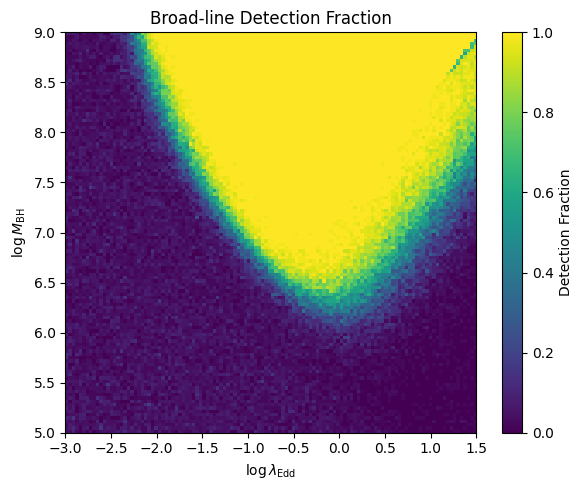

In [16]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np

def run_one_iteration(i, logMBH, logλEdd, z, rms_noise, narrow_flux, narrow_fwhm_kms,
                      reference_wavelength, R_fwhm_kms, ID, save_path):
    velocity, narrow_line, broad_line, broad_flux,total_flux, noisy_flux, flux_err, (LHa, broad_flux, FWHM_broad_kms) = simulate_line(
        logMBH=logMBH,
        logλEdd=logλEdd,
        z=z,
        rms_noise=rms_noise,
        narrow_flux=narrow_flux,
        narrow_fwhm_kms=narrow_fwhm_kms,
        R=1500,
        c=3e5,
        pixel_dlambda=20
    )
    is2 = 0
    is22 = 0
    is3 = 0
    # print(FWHM_broad_kms , narrow_fwhm_kms, narrow_flux/broad_flux )
    
    if(FWHM_broad_kms > narrow_fwhm_kms + 200 and FWHM_broad_kms < 1000 and broad_flux/narrow_flux > 0.4):
        # return [0, 1]
       is2 = 1
    # elif( broad_flux/narrow_flux > 10):
    #     # return [0, 1]
    #     BIC_two, BIC_one = 0, 1
    elif(FWHM_broad_kms < narrow_fwhm_kms + 200 and  broad_flux/narrow_flux > 0.8):
        # return [0, 1]
        is22 = 1
    elif(FWHM_broad_kms < narrow_fwhm_kms + 200 and broad_flux/narrow_flux > 0):
        # return [0, 1]
        is3 = 1
    
    # else:
    #    BIC_two, BIC_one = 1, 0
    # else:
    if(1):
        fit_line_id = f'{ID}_BH{logMBH}_nEd{logλEdd}'
        fig = None
        axess = None
        if i == 0:
            fig, axess = plt.subplots(2, 2, figsize=(10, 6),
                                      gridspec_kw={'height_ratios': [3, 1]},
                                      sharex=True)

        fit_line = EmissionLineFitter(velocity, noisy_flux, flux_err, z,
                                      reference_wavelength, R_fwhm_kms, fit_line_id=fit_line_id)

        veolcity_range = 5000
        fit_line.slice_region(velocity_range=veolcity_range)
        argmax = np.argmax(fit_line.flux_sliced)
        initmean = fit_line.v_sliced[argmax]

        initial_params_br = [
            {'amplitude': max(fit_line.flux_sliced)*1.2/0.3989423*(100/2.35482), 'mean': initmean, 'stddev': 800/2.35482,
             'mean_bounds': (-1000, 1000), 'std_bounds': (0, 1000/2.35482),
             'amp_bounds': (0, 5.5 * max(fit_line.flux_sliced)), 'tied_sigma': None},
            {'amplitude': max(fit_line.flux_sliced)*0.8/0.3989423*(1200/2.35482), 'mean': initmean, 'stddev': 1000/2.35482,
             'mean_bounds': (-300, 300), 'std_bounds': (0/2.35482, 5000/2.35482),
             'amp_bounds': (0, 5.5 * max(fit_line.flux_sliced)), 'tied_center': 0, 'tied_center_value': 0},
        ]
        fit_line.set_gaussian_components(len(initial_params_br), initial_params_br)
        fit_line.fit_emission_line()
        BIC_two = fit_line.BIC
        if i == 0:
            fit_line.external_plot([axess[0][0], axess[1][0]])

        initial_params_si = [
            {'amplitude': max(fit_line.flux_sliced)*1.2/0.3989423*(100/2.35482), 'mean': initmean, 'stddev': 800/2.35482,
             'mean_bounds': (-1000, 1000), 'std_bounds': (0, 1000/2.35482),
             'amp_bounds': (0, 5.5 * max(fit_line.flux_sliced)), 'tied_sigma': None},
        ]
        fit_line.set_gaussian_components(len(initial_params_si), initial_params_si)
        fit_line.fit_emission_line()
        BIC_one = fit_line.BIC
        if i == 0:
            fit_line.external_plot([axess[0][1], axess[1][1]])
            plt.savefig(save_path + fit_line_id + f'_{i}.png')
            plt.close(fig)

    return [BIC_two, BIC_one, is2, is22, is3]



reference_wavelength = 6563
R_fwhm_kms = c / R
pixel_dv = 100
pixel_dlamdba = reference_wavelength * pixel_dv / c
iter_num = 50

logMBH_list = np.linspace(5, 9, 120)
logλEdd_list = np.linspace(-3, 1.5, 120)

# ID = 8219
# rms_noise = 3.579498477581536e-20
# narrow_flux = 2.967e-18
# narrow_fwhm_kms = 131.86
# z = 6.785

# ID = 12329
# rms_noise = 4.608264966243551e-20
# narrow_flux = 3.926e-18
# narrow_fwhm_kms = 283.64
# z = 6.62

# ID = 16321 114256
# rms_noise = 2.633066260924914e-20
# narrow_flux = 1.611e-18
# narrow_fwhm_kms = 473.50
# z = 4.985

# ID = 20547 114111
# rms_noise = 1.9275543094251015e-20
# narrow_flux = 1.124e-18
# narrow_fwhm_kms = 268.42
# z = 5.278

# ID = 22015 #123420
# rms_noise = 3.0067429858357437e-20
# narrow_flux = 2.021e-18
# narrow_fwhm_kms = 207.60
# z = 5.127

ID_list = [8219, 12329, 16321, 20547, 22015]
rms_noise_list = [3.579498477581536e-20, 4.608264966243551e-20, 2.633066260924914e-20, 1.9275543094251015e-20, 3.0067429858357437e-20]
narrow_flux_list = [2.967e-18, 3.926e-18, 1.611e-18,  1.124e-18, 2.021e-18]
narrow_fwhm_kms_list  = [131.86, 283.64, 473.50, 268.42, 207.60]
z_list = [6.785, 6.62, 4.985, 5.278,5.127]

for (ID, rms_noise, narrow_flux, narrow_fwhm_kms, z) in zip(ID_list, rms_noise_list, narrow_flux_list, narrow_fwhm_kms_list, z_list):
    # 构建一个 detection 数组
    if(ID!=22015):
        continue
    detection_matrix = np.zeros((len(logMBH_list), len(logλEdd_list)))
    detection_matrix2 = np.zeros((len(logMBH_list), len(logλEdd_list)))
    detection_matrix22 = np.zeros((len(logMBH_list), len(logλEdd_list)))
    detection_matrix3 = np.zeros((len(logMBH_list), len(logλEdd_list)))

    save_path = f'/Users/zijianzhang/Astro_Data/LRD_SPEC/BL_simulation/{ID}_revised_2/'
    os.makedirs(save_path, exist_ok=True)

    # 外层循环
    # for i_MB, logMBH in enumerate(logMBH_list):
    #     for i_Edd, logλEdd in enumerate(logλEdd_list):
    #         logMBH = np.round(logMBH, 2)
    #         logλEdd = np.round(logλEdd, 2)

    #         tasks = (delayed(run_one_iteration)(
    #             i, logMBH, logλEdd, z, rms_noise, narrow_flux, narrow_fwhm_kms,
    #             reference_wavelength, R_fwhm_kms, ID, save_path
    #         ) for i in range(iter_num))

    #         results = Parallel(n_jobs=-1, backend="loky")(
    #             tqdm(tasks, total=iter_num, desc=f"MBH={logMBH}, λEdd={logλEdd}")
    #         )

    #         BIC_list = np.array(results)
    #         detection_num = np.sum(BIC_list[:, 1] > BIC_list[:, 0])
    #         equal_num = np.sum(BIC_list[:, 1] == BIC_list[:, 0])
    #         detection_matrix[i_MB, i_Edd] = detection_num / iter_num
    #         detection_matrix2[i_MB, i_Edd] = equal_num / iter_num

    tasks_outer = []
    for i_MB, logMBH in enumerate(logMBH_list):
        for i_Edd, logλEdd in enumerate(logλEdd_list):
            logMBH = np.round(logMBH, 2)
            logλEdd = np.round(logλEdd, 2)
            tasks_outer.append((i_MB, i_Edd, logMBH, logλEdd))

    def process_one_cell(i_MB, i_Edd, logMBH, logλEdd):
        BIC_list = []
        for i in range(iter_num):  # 内层改成普通循环
            result = run_one_iteration(
                i, logMBH, logλEdd, z, rms_noise, narrow_flux, narrow_fwhm_kms,
                reference_wavelength, R_fwhm_kms, ID, save_path
            )
            BIC_list.append(result)

        BIC_list = np.array(BIC_list)
        detection_num = np.sum(BIC_list[:, 1] > BIC_list[:, 0])
        equal_num = np.sum(BIC_list[:, 1] == BIC_list[:, 0])
        # one_num = np.sum(BIC_list[:, 1] == BIC_list[:, 0] + 1)
        return i_MB, i_Edd, detection_num / iter_num, BIC_list[0, 2], BIC_list[0, 3], BIC_list[0, 4]


    results_outer = Parallel(n_jobs=-1, backend="loky")(
        delayed(process_one_cell)(i_MB, i_Edd, logMBH, logλEdd)
        for (i_MB, i_Edd, logMBH, logλEdd) in tqdm(tasks_outer, desc="Outer loop")
    )

    for i_MB, i_Edd, det_frac, eq_frac, eq_frac2, one_frac in results_outer:
        detection_matrix[i_MB, i_Edd] = det_frac
        detection_matrix2[i_MB, i_Edd] = eq_frac
        detection_matrix22[i_MB, i_Edd] = eq_frac2
        detection_matrix3[i_MB, i_Edd] = one_frac
    # save the detection matrix
    np.save(save_path + 'detection_matrix.npy', detection_matrix)
    np.save(save_path + 'detection_matrix2.npy', detection_matrix2)
    np.save(save_path + 'detection_matrix22.npy', detection_matrix22)
    np.save(save_path + 'detection_matrix3.npy', detection_matrix3)
    # plot the detection matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(
        detection_matrix, 
        origin='lower', 
        aspect='auto',
        extent=[
            logλEdd_list[0], logλEdd_list[-1],
            logMBH_list[0], logMBH_list[-1]
        ],
        cmap='viridis',
        vmin=0, vmax=1
    )

    # 添加颜色条
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Detection Fraction')

    # 设置坐标轴标签和刻度
    ax.set_xlabel(r'$\log \lambda_{\rm Edd}$')
    ax.set_ylabel(r'$\log M_{\rm BH}$')
    ax.set_title('Broad-line Detection Fraction')

    plt.tight_layout()
    plt.savefig(save_path + 'detection_map.png', dpi=150)
    plt.show()



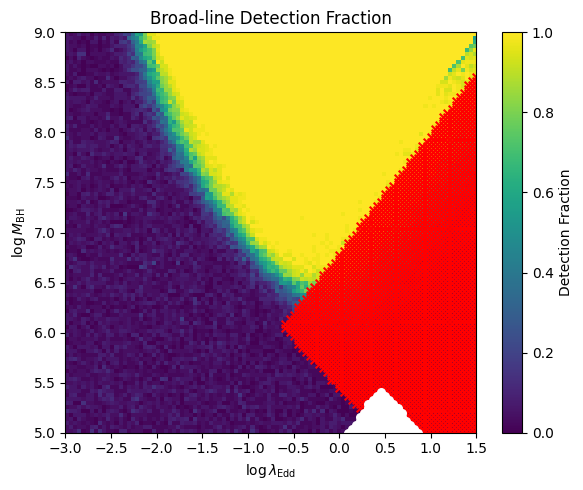

In [5]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(
    detection_matrix, 
    origin='lower', 
    aspect='auto',
    extent=[
        logλEdd_list[0], logλEdd_list[-1],
        logMBH_list[0], logMBH_list[-1]
    ],
    cmap='viridis',
    vmin=0, vmax=1
)

# detection_matrix2 == 1 的区域用红色虚线框出
# ax.contour(
#     logλEdd_list, logMBH_list, detection_matrix2 == 1,
#     levels=[0.5], colors='red', linestyles='--', linewidths=1.5,
#     label='Equal BIC'
# )

# # detection_matrix3 == 1 的区域用白色实线框出
# ax.contour(
#     logλEdd_list, logMBH_list, detection_matrix3 == 1,
#     levels=[0.5], colors='white', linestyles='-', linewidths=1.5,
#     label='Another Condition'
# )
y_idx, x_idx = np.where(detection_matrix2 == 1)
ax.scatter(logλEdd_list[x_idx], logMBH_list[y_idx], s=30, c='red', marker='x', label='Equal BIC')

y_idx, x_idx = np.where(detection_matrix3 == 1)
ax.scatter(logλEdd_list[x_idx], logMBH_list[y_idx], s=30, c='white', marker='o', facecolors='none', label='Condition 3')

# 添加颜色条
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Detection Fraction')

# 设置坐标轴标签和刻度
ax.set_xlabel(r'$\log \lambda_{\rm Edd}$')
ax.set_ylabel(r'$\log M_{\rm BH}$')
ax.set_title('Broad-line Detection Fraction')
plt.tight_layout()

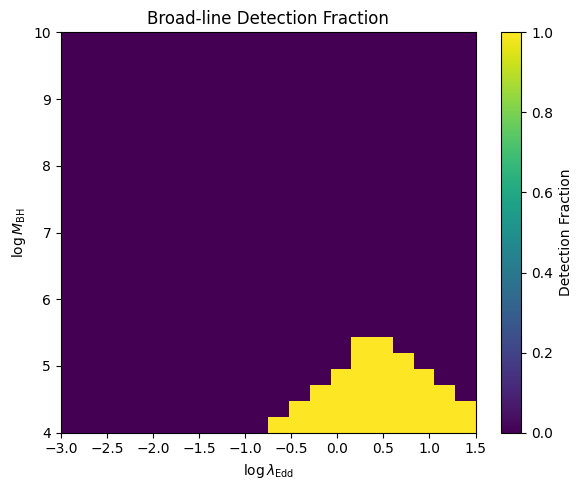

In [81]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(
    detection_matrix2, 
    origin='lower', 
    aspect='auto',
    extent=[
        logλEdd_list[0], logλEdd_list[-1],
        logMBH_list[0], logMBH_list[-1]
    ],
    cmap='viridis',
    vmin=0, vmax=1
)

# 添加颜色条
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Detection Fraction')

# 设置坐标轴标签和刻度
ax.set_xlabel(r'$\log \lambda_{\rm Edd}$')
ax.set_ylabel(r'$\log M_{\rm BH}$')
ax.set_title('Broad-line Detection Fraction')

plt.tight_layout()
plt.savefig(save_path + 'detection_map.png', dpi=150)
plt.show()

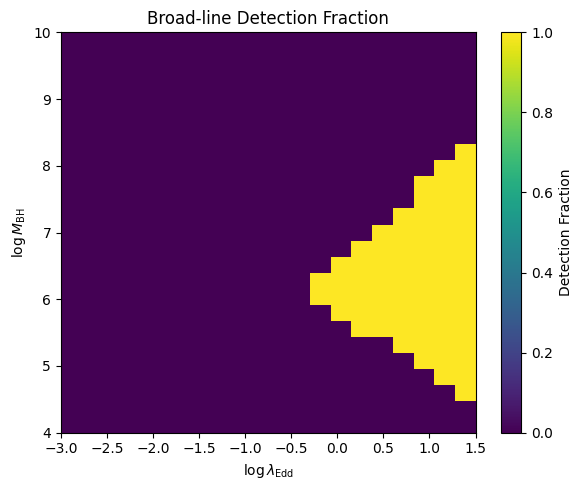

In [51]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(
    detection_matrix3, 
    origin='lower', 
    aspect='auto',
    extent=[
        logλEdd_list[0], logλEdd_list[-1],
        logMBH_list[0], logMBH_list[-1]
    ],
    cmap='viridis',
    vmin=0, vmax=1
)

# 添加颜色条
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Detection Fraction')

# 设置坐标轴标签和刻度
ax.set_xlabel(r'$\log \lambda_{\rm Edd}$')
ax.set_ylabel(r'$\log M_{\rm BH}$')
ax.set_title('Broad-line Detection Fraction')

plt.tight_layout()
plt.savefig(save_path + 'detection_map.png', dpi=150)
plt.show()

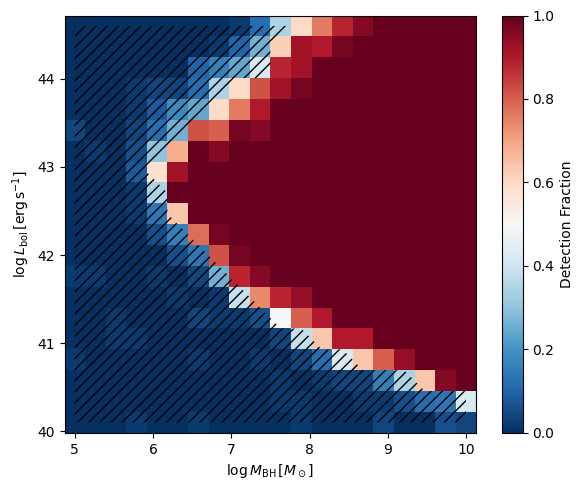

In [9]:
logLedd = np.log10(1.26e38) + logMBH_list[:, None]  # shape (nMBH, 1)
logLbol_grid = logλEdd_list[None, :] + logLedd      # shape (nMBH, nEdd)

# detection mask
mask = detection_matrix < 0.5

fig, ax = plt.subplots(figsize=(6, 5))
# 用 pcolormesh 画出背景（可选）
pcm = ax.pcolormesh(logMBH_list, logLbol_grid[0], detection_matrix.T,
                    shading="auto", cmap="RdBu_r", vmin=0, vmax=1)
plt.colorbar(pcm, label="Detection Fraction")

# 用等高线画出感兴趣区域
ax.contourf(logMBH_list, logLbol_grid[0], mask.T,
            levels=[0.5, 1], colors="none", hatches=["///"], alpha=0)

ax.set_xlabel(r"$\log M_{\rm BH}\,[M_\odot]$")
ax.set_ylabel(r"$\log L_{\rm bol}\,[\mathrm{erg\,s^{-1}}]$")
plt.tight_layout()
plt.show()

In [78]:
np.where(BIC_list.T[1] > BIC_list.T[0])[0]


array([87])

In [ ]:
fit_line.external_plot(ax)

In [ ]:
# 未并行版本的备份

for i_MB, logMBH in enumerate(logMBH_list):
    for i_Edd, logλEdd in enumerate(logλEdd_list):
        logMBH = np.round(logMBH, 2)
        logλEdd = np.round(logλEdd, 2)
        BIC_list = []
        for i in range(iter_num):
            velocity, narrow_line, broad_line, total_flux, noisy_flux, flux_err, (LHa, FWHM_broad_kms) = simulate_line(
                logMBH = logMBH,
                logλEdd = logλEdd,
                z = z,
                rms_noise = rms_noise,
                narrow_flux = narrow_flux,
                narrow_fwhm_kms = narrow_fwhm_kms,
                R = 1500,
                c = 3e5,
                pixel_dlambda = 20
                )
            print(LHa, FWHM_broad_kms)


            fit_line_id = f'{ID}_BH{logMBH}_nEd{logλEdd}'
            if(i == 0):
                fig, axess = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
            fit_line = EmissionLineFitter(velocity, noisy_flux, flux_err, z, reference_wavelength, R_fwhm_kms, fit_line_id=fit_line_id)
            # 截取波长范围
            # veolcity_range = 7000
            veolcity_range = 5000
            fit_line.slice_region(velocity_range=veolcity_range)
            argmax = np.argmax(fit_line.flux_sliced)
            initmean = fit_line.v_sliced[argmax]
            initial_params_br = [
                {'amplitude': max(fit_line.flux_sliced)*1.2/0.3989423*(100/2.35482), 'mean': initmean, 'stddev': 800/2.35482, 
                            'mean_bounds': (-1000, 1000) , 'std_bounds':(0, 1000/2.35482), 'amp_bounds':(0, 5.5 * max(fit_line.flux_sliced)), 'tied_sigma': None},  #
                {'amplitude': max(fit_line.flux_sliced)*0.8/0.3989423*(1200/2.35482), 'mean': initmean, 'stddev': 1000/2.35482, 
                        'mean_bounds': (-300, 300) , 'std_bounds': (1000/2.35482, 5000/2.35482), 'amp_bounds':(0,  5.5 * max(fit_line.flux_sliced)), 'tied_center': 0, 'tied_center_value': 0},
            ]
            fit_line.set_gaussian_components(len(initial_params_br), initial_params_br)
            fit_line.fit_emission_line()
            BIC_two = fit_line.BIC
            # fit_line.calculate_flux_ew_fwhm()
            id_fit = 0
            if(i == 0):
                fit_line.external_plot([axess[0][id_fit], axess[1][id_fit]])
            initial_params_si = [
                {'amplitude': max(fit_line.flux_sliced)*1.2/0.3989423*(100/2.35482), 'mean': initmean, 'stddev': 800/2.35482, 
                            'mean_bounds': (-1000, 1000) , 'std_bounds':(0, 1000/2.35482), 'amp_bounds':(0, 5.5 * max(fit_line.flux_sliced)), 'tied_sigma': None},  #
            ]
            fit_line.set_gaussian_components(len(initial_params_si), initial_params_si)
            fit_line.fit_emission_line()
            BIC_one = fit_line.BIC
            # fit_line.calculate_flux_ew_fwhm()
            id_fit = 1
            if(i == 0):
                fit_line.external_plot([axess[0][id_fit], axess[1][id_fit]])

            if(i == 0):
                plt.savefig(save_path + fit_line_id + f'_{i}.png')
            plt.close()
            BIC_list.append([BIC_two, BIC_one])
        BIC_list = np.array(BIC_list)
        detection_num = len(np.where(BIC_list.T[1] > BIC_list.T[0])[0])
        detection_matrix[i_MB, i_Edd] = detection_num / iter_num#

ValueError: too many values to unpack (expected 6)

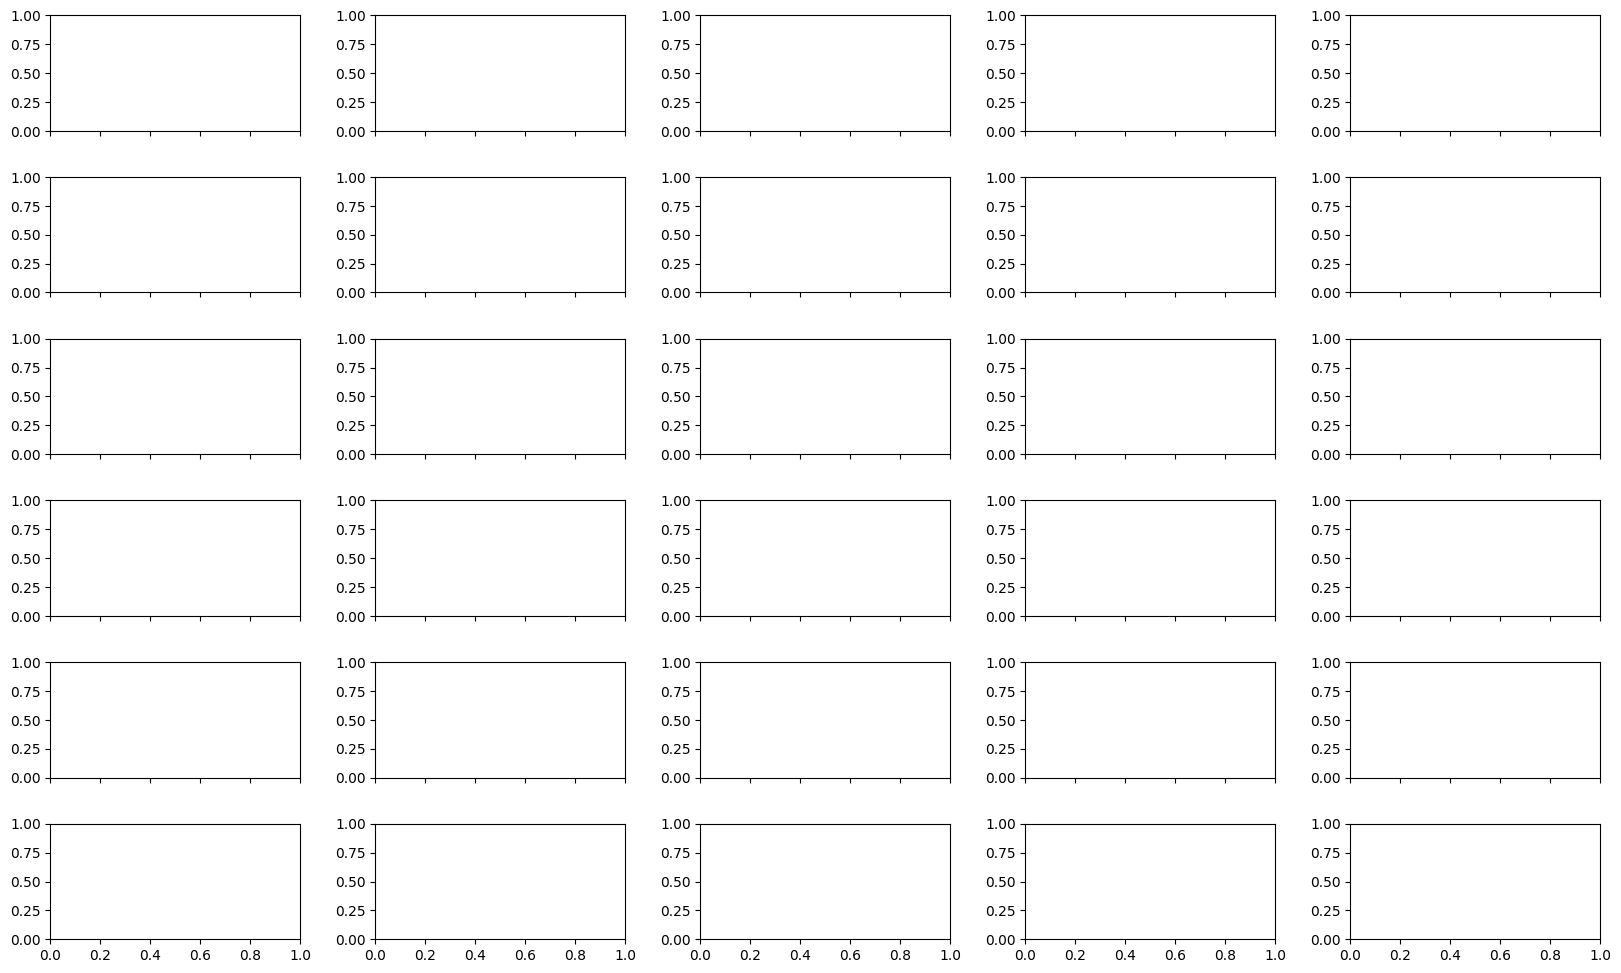

In [13]:
logMBH_list = np.linspace(5, 9, 6)
logλEdd_list = np.linspace(-2, 1, 5)

fig, axes = plt.subplots(6, 5, figsize=(20, 12), sharex=True, sharey=False)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, logMBH in enumerate(logMBH_list):
    for j, logλEdd in enumerate(logλEdd_list):
        ax = axes[i, j]
        
        velocity, narrow_line, broad_line, total_flux, noisy_flux, (LHa, FWHM_broad_kms) = simulate_line(
            logMBH=logMBH,
            logλEdd=logλEdd,
            z=6,
            rms_noise=3e-20,
            narrow_flux=2.967e-18,
            narrow_fwhm_kms=131.86,
            R=1600,
            c=3e5,
            pixel_dlambda=10
        )

        ax.plot(velocity, noisy_flux, color='gray', drawstyle='steps-mid', lw=0.8)
        ax.plot(velocity, narrow_line, color='blue', lw=0.8)
        ax.plot(velocity, broad_line, color='green', lw=0.8)

        ax.axvline(0, color='black', linestyle=':', lw=0.5)
        
        # 小字体文本，防止遮挡
        textstr = (
            r'$L_{\mathrm{H}\alpha}=%.1e$' '\n'
            r'FWHM=%.0f' '\n'
            r'$M_{\mathrm{BH}}=10^{%.1f}M_\odot$' '\n'
            r'$\log\lambda_{\mathrm{Edd}}=%.1f$'
        ) % (LHa, FWHM_broad_kms, logMBH, logλEdd)
        ax.text(0.03, 0.95, textstr, transform=ax.transAxes,
                fontsize=10, va='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.6, lw=0))

        # 只在边缘加 label
        if i == 9:
            ax.set_xlabel('v [km/s]', fontsize=8)
        if j == 0:
            ax.set_ylabel('Flux', fontsize=8)

        ax.tick_params(labelsize=6)
        # ax.set_xlim(-2000, 2000)
        # ax.set_ylim(-rms_noise*5, max(narrow_line.max(), broad_line.max())*1.5)

# 总标题
# fig.suptitle('Simulated Hα Spectra in Velocity Space\n(logMBH vs logλEdd)', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
# ----------------------
# 💡 用 lmfit 拟合 velocity 空间上的双高斯
# ----------------------
model_narrow = GaussianModel(prefix='n_')
model_broad = GaussianModel(prefix='b_')
model = model_narrow + model_broad

params = Parameters()
params.add('n_center', value=0.0, vary=False)
params.add('n_sigma', value=total_narrow_fwhm_kms * gaussian_fwhm_to_sigma, vary=False)
params.add('n_amplitude', value=narrow_flux, min=0)

params.add('b_center', value=0.0, min=-1000, max=1000)
params.add('b_sigma', value=FWHM_broad_kms * gaussian_fwhm_to_sigma, min=100, max=5000)
params.add('b_amplitude', value=broad_flux, min=0)

result = model.fit(noisy_flux, params, x = velocity)

# ----------------------
# 绘图
# ----------------------
plt.figure(figsize=(10, 5))
plt.plot(velocity, noisy_flux, color='gray', label='Noisy Spectrum', drawstyle='steps-mid')
plt.plot(velocity, result.best_fit, color='red', label='Double Gaussian Fit')
plt.plot(velocity, narrow_line, color='red', label='Narrow line')
plt.plot(velocity, broad_line, color='red', label='Broad line')
plt.plot(velocity, result.eval_components()['n_'], '--', color='blue', label='Narrow Fit')
plt.plot(velocity, result.eval_components()['b_'], '--', color='green', label='Broad Fit')
plt.xlabel('Velocity [km/s]')
plt.ylabel('Flux')
plt.legend()
plt.title('Hα Double Gaussian Fit in Velocity Space')
plt.axvline(0, color='black', linestyle=':', alpha=0.5)
plt.show()

# ----------------------
# 打印拟合结果
# ----------------------
print(result.fit_report())


NameError: name 'total_narrow_fwhm_kms' is not defined

Outer loop:   2%|▏         | 47/2500 [02:42<2:21:43,  3.47s/it]


ValueError: x and y must have same first dimension, but have shapes (200,) and (2000,)

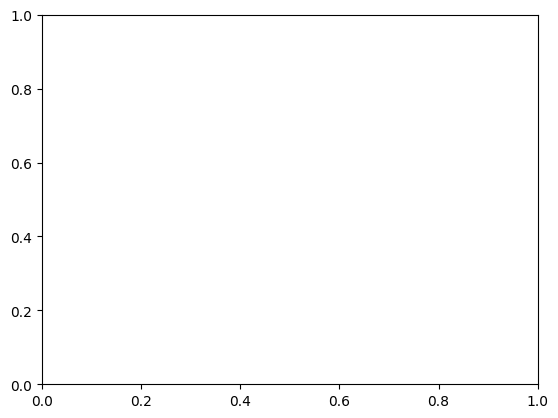

In [8]:
plt.plot(velocity, narrow_line)
plt.plot(velocity, total_flux)

In [ ]:
# ----------------------
# 窄线模拟（加instrument分辨率）
amp = 1.35e-16
width_v = 90
peak = 0.3989423*amp / (width_v)
width_AA = width_v * 6563 / const.c.to('km/s').value
flux = peak * width_AA * np.sqrt(2 * np.pi)
# ----------------------
# Instrument + intrinsic FWHM 合成


In [9]:
R_fwhm_kms = c / R
total_narrow_fwhm_kms = np.sqrt(narrow_fwhm_kms**2 + R_fwhm_kms**2)
total_narrow_fwhm_A = lambda_rest * total_narrow_fwhm_kms / c
sigma_narrow_A = fwhm_to_sigma(total_narrow_fwhm_A)
sigma_narrow_kms = fwhm_to_sigma(total_narrow_fwhm_kms)
peak_narrow = narrow_flux/sigma_narrow_A/np.sqrt(2 * np.pi)
amp_narrow = peak_narrow/0.3989423*sigma_narrow_kms
# ----------------------
# lmfit Parameters 构造窄线模型
# ----------------------
params_narrow = Parameters()
params_narrow.add('amplitude', value=amp_narrow)
params_narrow.add('center', value=0)
params_narrow.add('sigma', value=sigma_narrow_A)

# ----------------------
# 生成模拟窄线
# ----------------------
model_narrow = GaussianModel()
narrow_line = model_narrow.eval(params_narrow, x=velocity)

NameError: name 'fwhm_to_sigma' is not defined

In [10]:
params_narrow = Parameters()
params_narrow.add('amplitude', value=amp_narrow)
params_narrow.add('center', value=0)
params_narrow.add('sigma', value = sigma_narrow_kms)
model_narrow = GaussianModel()
narrow_line = model_narrow.eval(params_narrow, x=velocity)


plt.plot(velocity, narrow_line)

NameError: name 'amp_narrow' is not defined

ValueError: x and y must have same first dimension, but have shapes (200,) and (2000,)

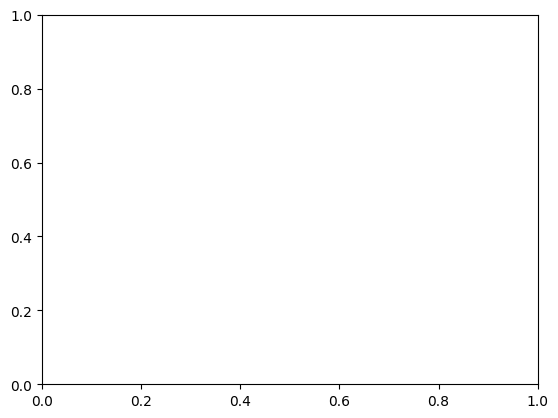

In [11]:
plt.plot(velocity, narrow_line)

In [12]:
peak_narrow 

NameError: name 'peak_narrow' is not defined

In [232]:
sigma_narrow_kms

97.34216210859857

In [190]:
width_AA 



1.9702630411069249

In [173]:
total_narrow_fwhm_kms

229.22327455998007

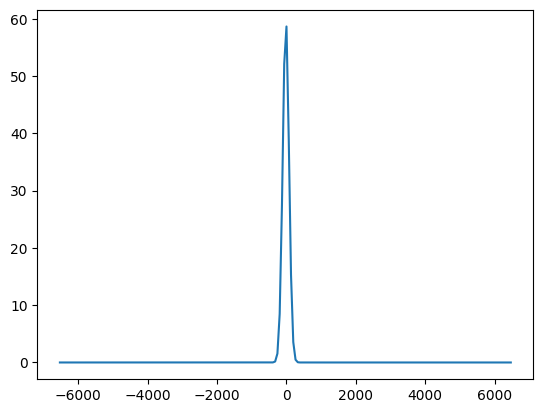

In [242]:
params_narrow.add('amplitude', value=1.35e4)
params_narrow.add('center', value=-18)
params_narrow.add('sigma', value=90)

# ----------------------
# 生成模拟窄线
# ----------------------
model_narrow = GaussianModel()
narrow_line = model_narrow.eval(params_narrow, x=velocity)

plt.plot(velocity, narrow_line)

In [ ]:


flux

2.955394706848055e-18

In [172]:
sigma_narrow

14.90665423143709

In [165]:
narrow_amp 

7.940492397380435e-20

In [160]:
fwhm_to_sigma(total_narrow_fwhm_A)

14.90665423143709

In [161]:
total_narrow_fwhm_kms

229.22327455998007

In [134]:
total_narrow_fwhm_A


50.129984276372404

In [132]:
narrow_amp 


5.560166128389551e-20